In [1]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [2]:
in_dir = 'D:/GraduateWorkData/nifti_files2/22vs8'
model_dir = 'D:/GraduateWorkData/nifti_files2/22vs8/results' 

In [3]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

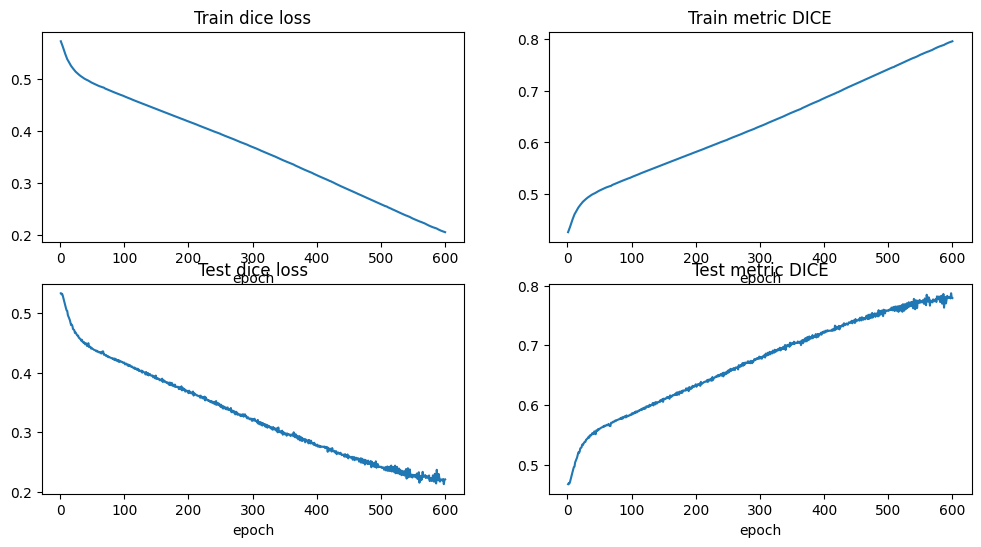

In [4]:
plt.figure("Results 26 may", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("Test dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("Test metric DICE")
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.show()

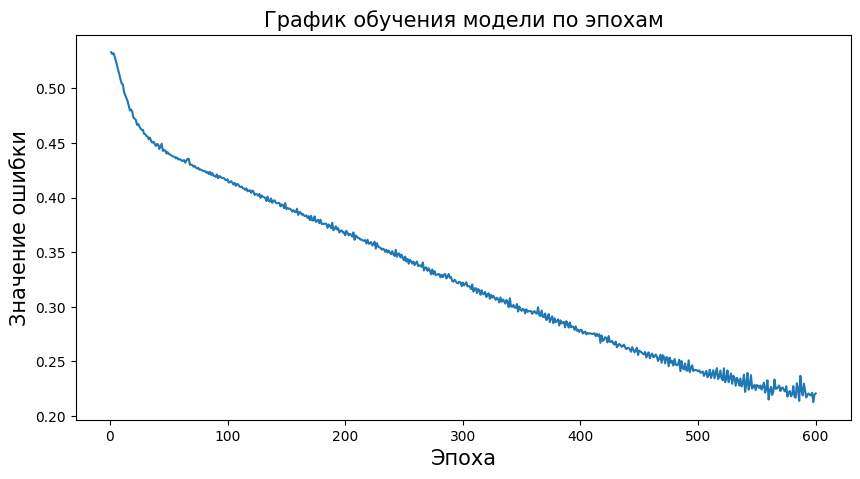

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title('График обучения модели по эпохам', fontsize=15)
plt.xlabel('Эпоха', fontsize=15)
plt.ylabel('Значение ошибки', fontsize=15)

x = [i + 1 for i in range(len(test_loss))]
y = test_loss

plt.plot(x, y)

plt.savefig('D:/универ (D)/4 КУРС/диплом/Диплом отчет/plot1.png')

plt.show()

In [7]:
np.max(test_metric)

0.7874575406312943

In [5]:
path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainImages", "*.nii.gz")))
path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainLabels", "*.nii.gz")))

path_test_volumes = sorted(glob(os.path.join(in_dir, "TestImages", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(in_dir, "TestLabels", "*.nii.gz")))

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
#test_files = test_files[0:9]

In [117]:
test_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(2, 2, 1.5), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-100, a_max=400,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

In [118]:
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

train_ds = Dataset(data=train_files, transform=test_transforms)
train_loader = DataLoader(train_ds, batch_size=1)

In [119]:
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [120]:
model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


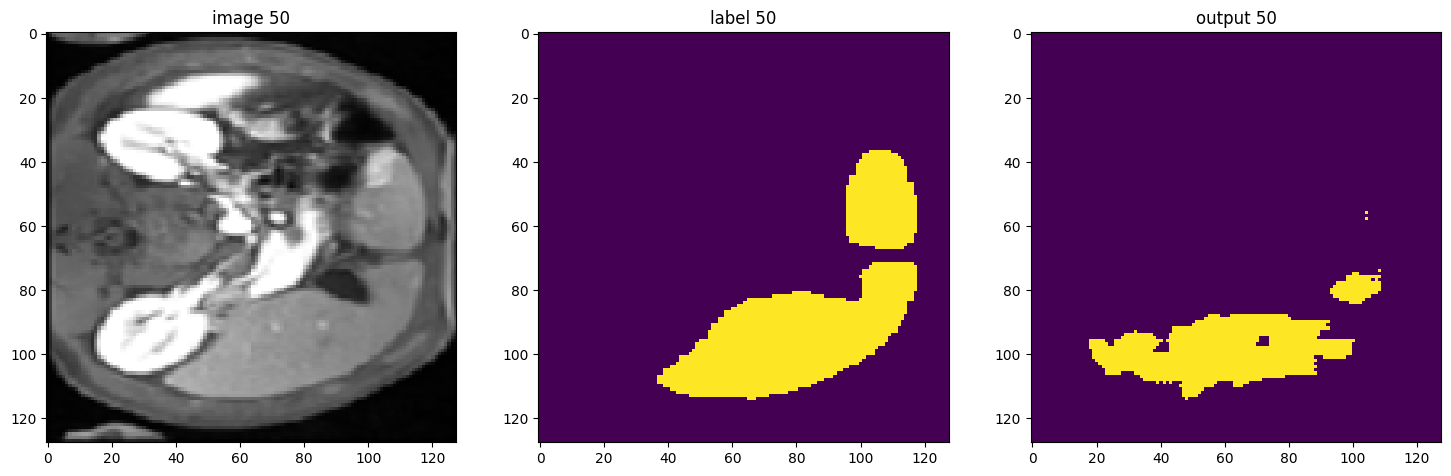

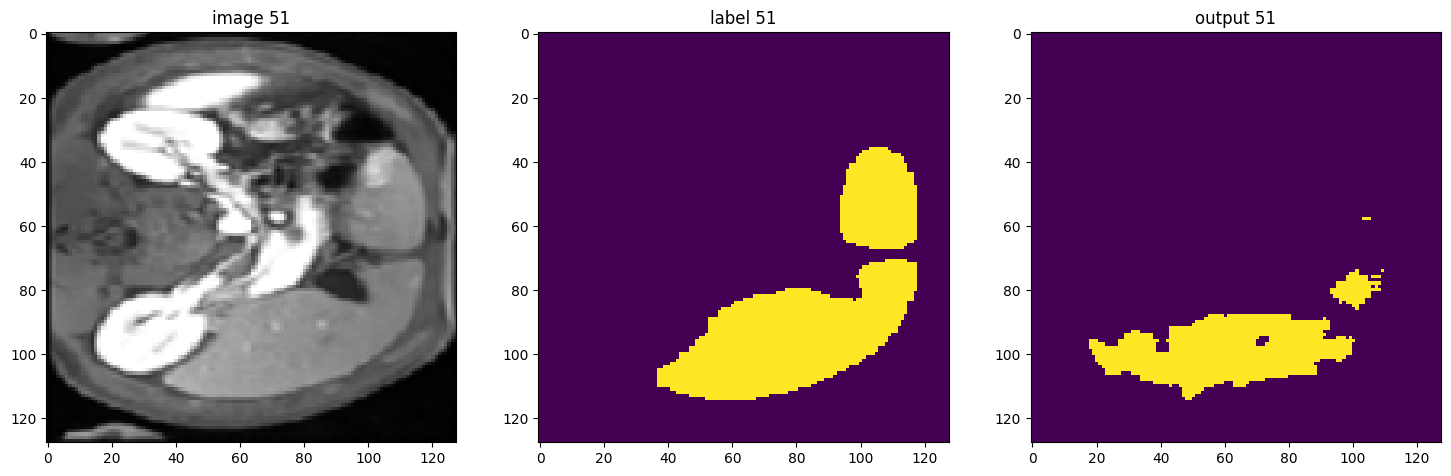

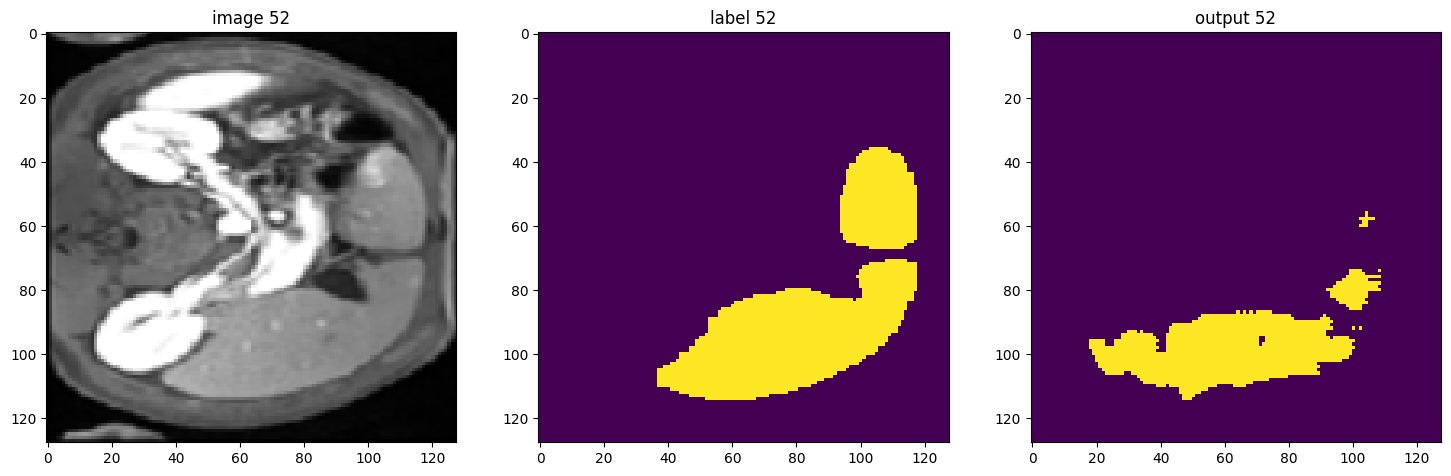

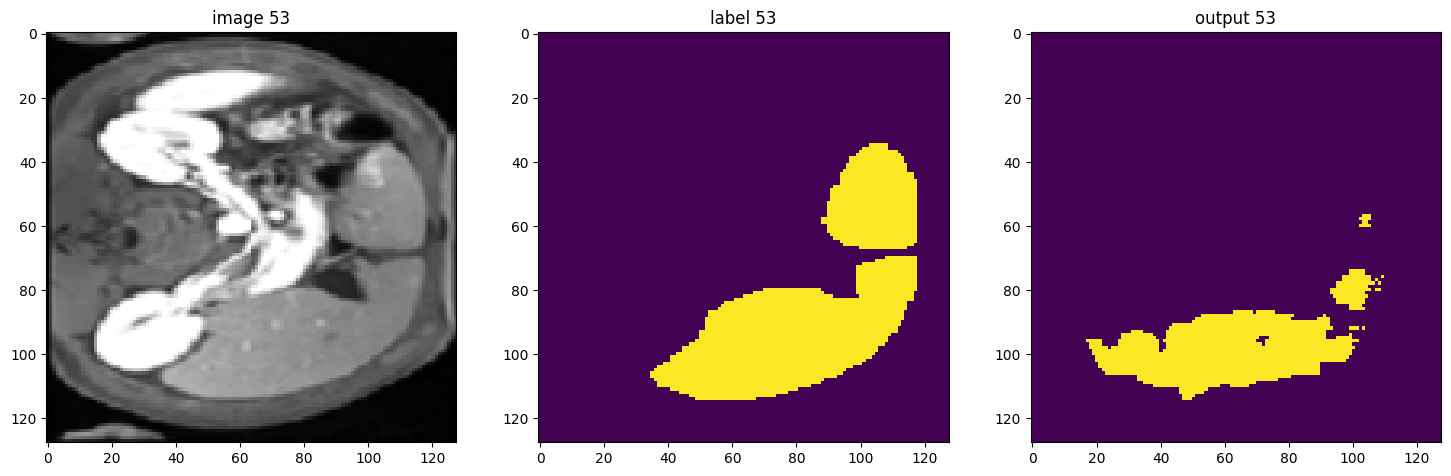

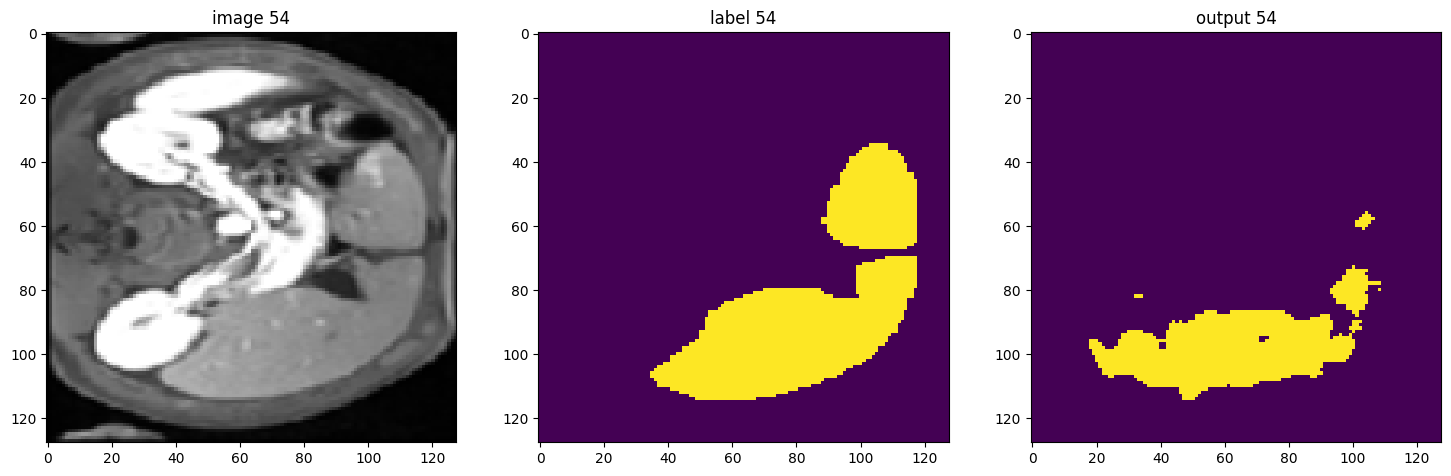

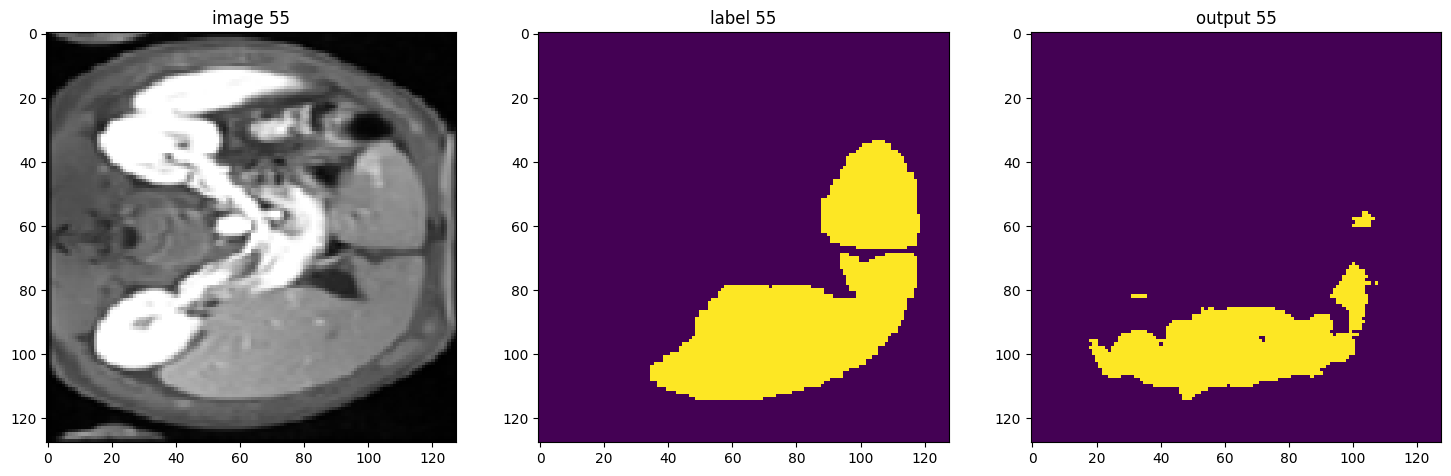

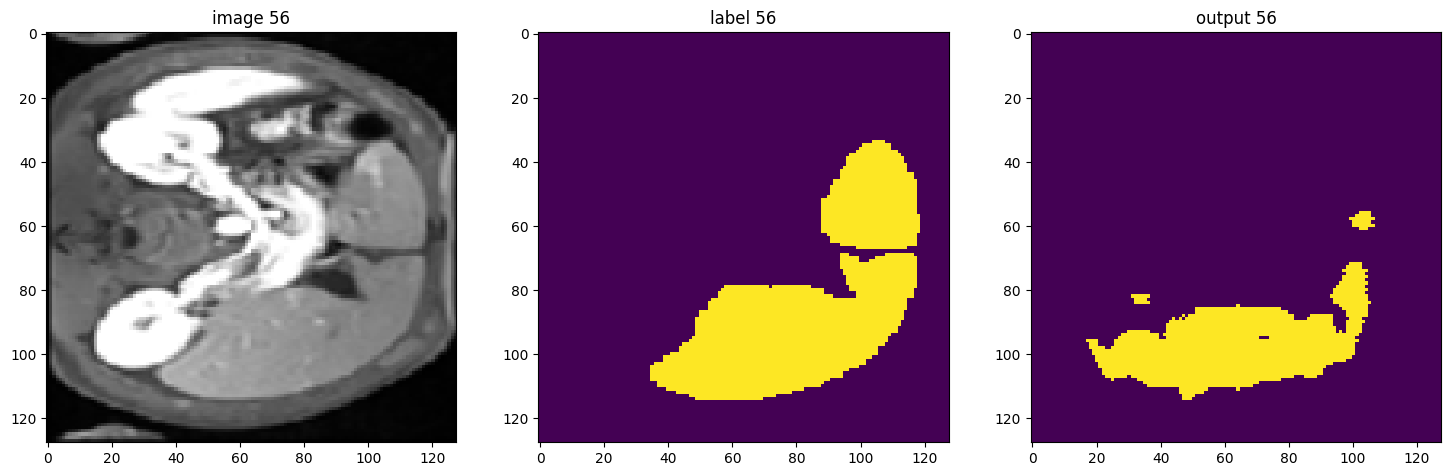

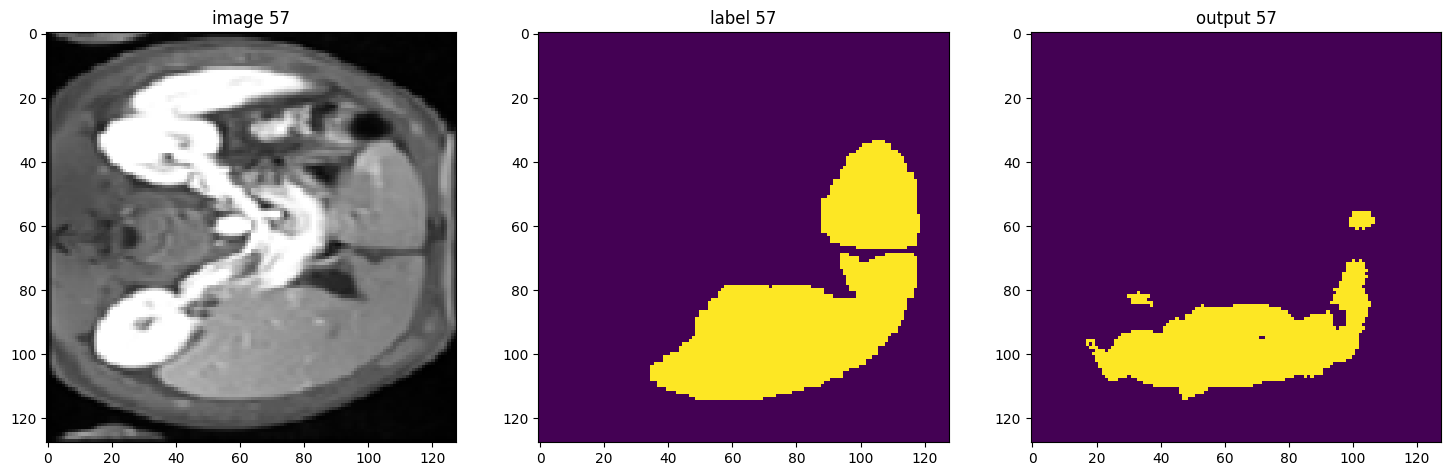

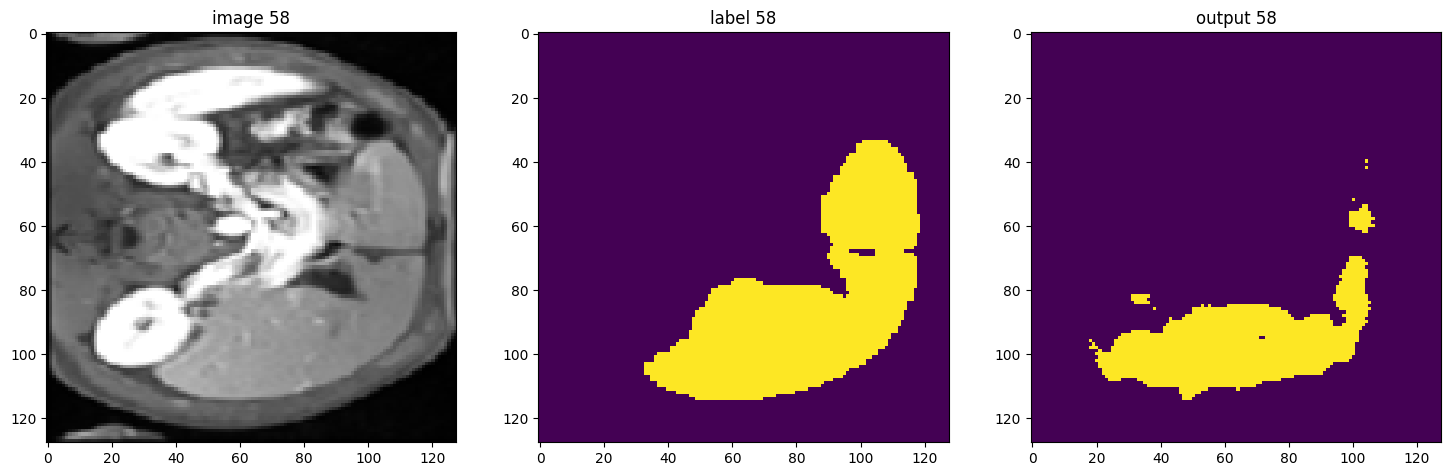

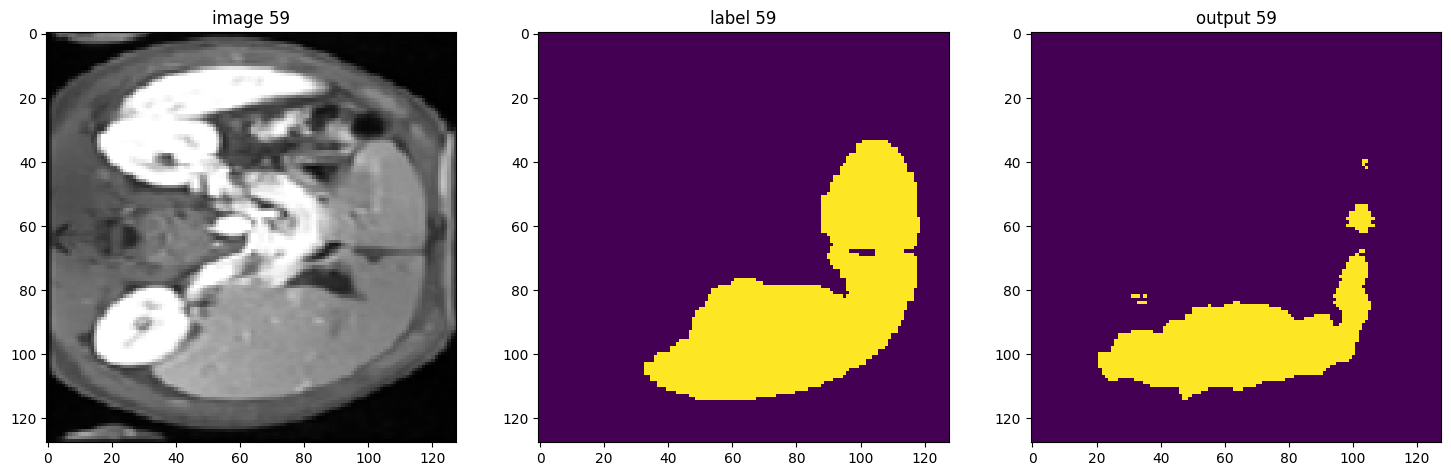

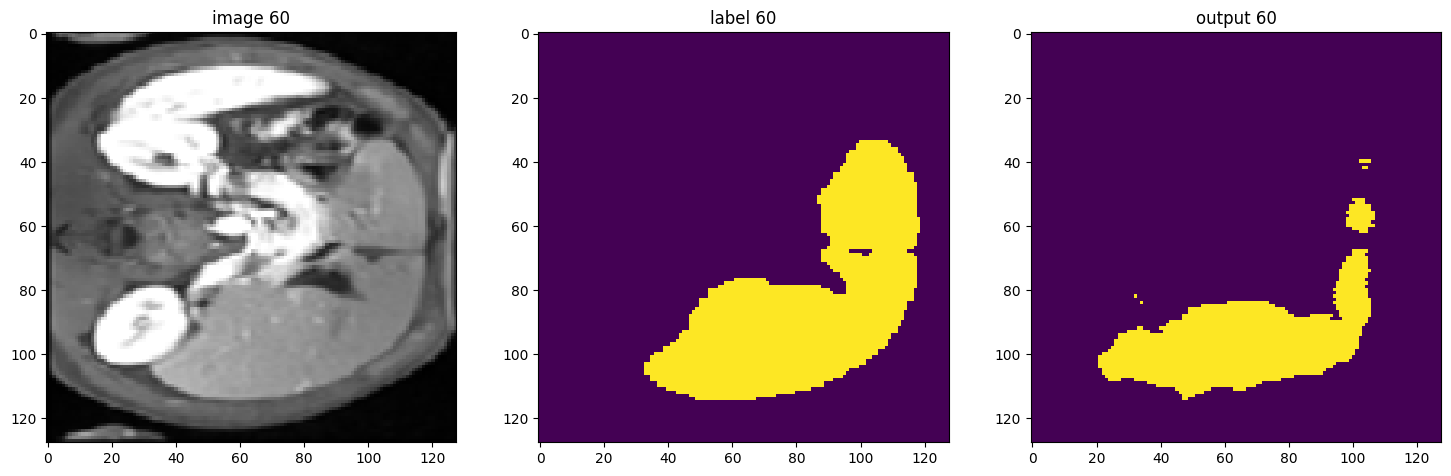

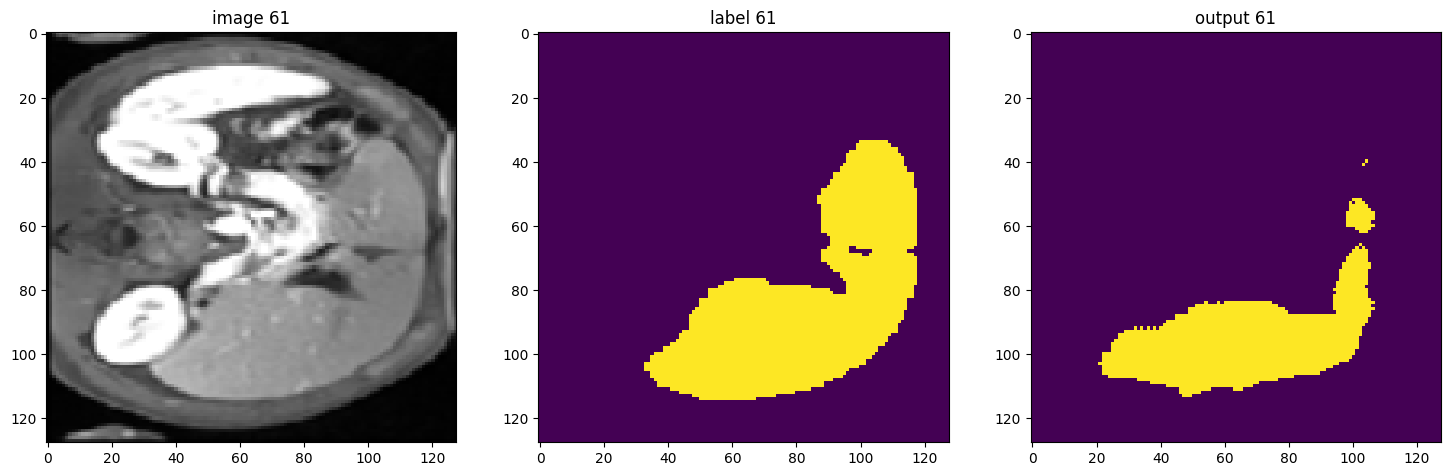

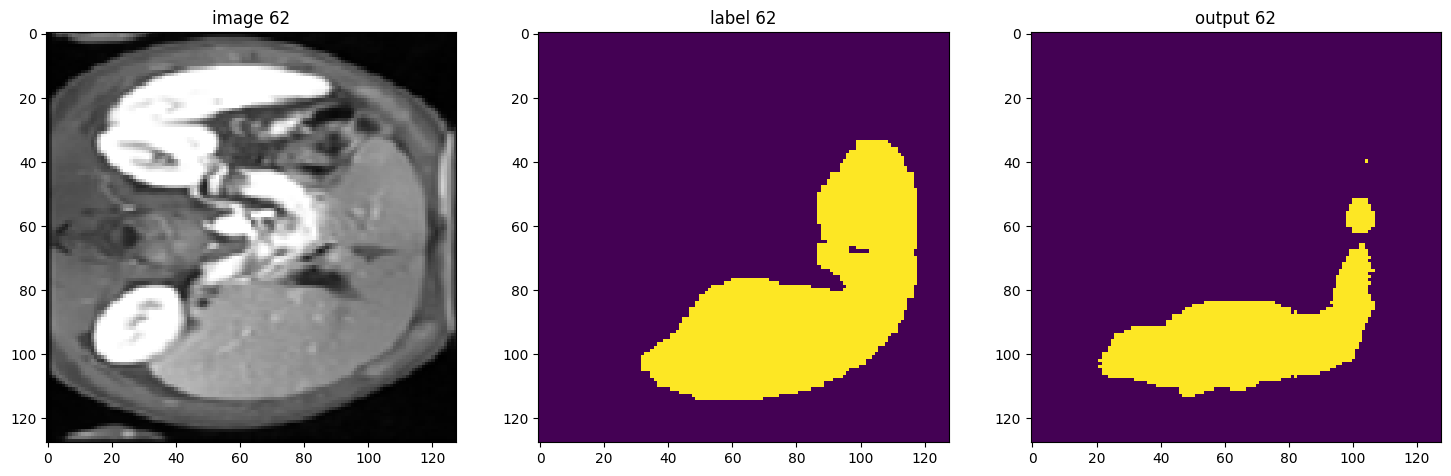

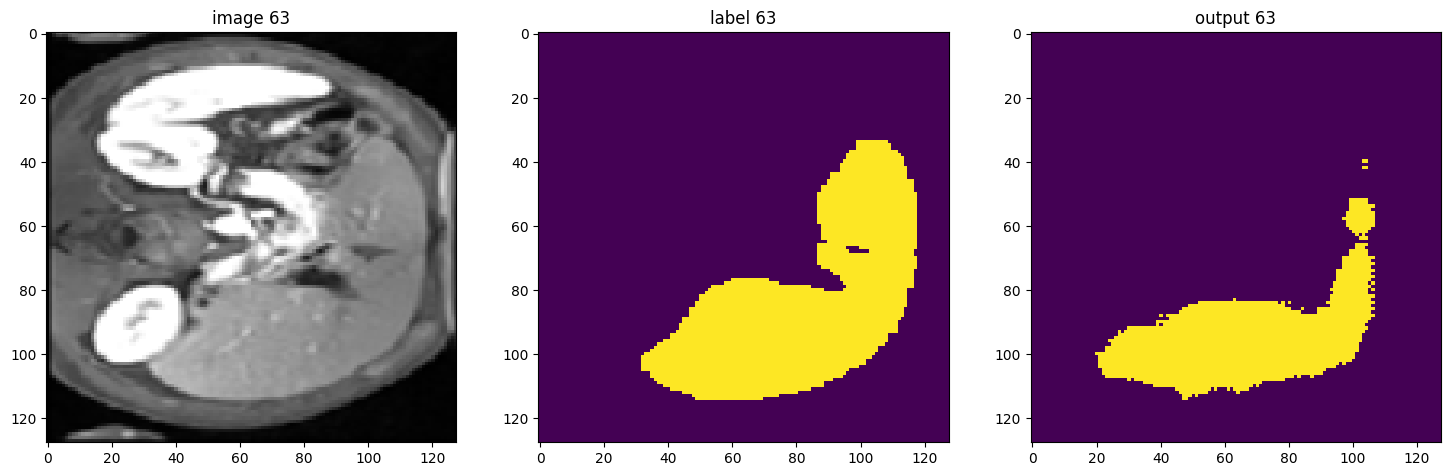

In [123]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    processed_images = []
    for j, test_patient in enumerate(test_loader): 
        if j == 1:

            max_img = np.array([0])
            max_seg = np.array([0])
            max_sum = np.sum(np.nonzero(max_img))

            t_volume = test_patient['vol']
            
            test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
            sigmoid_activation = Activations(sigmoid=True)
            test_outputs = sigmoid_activation(test_outputs)
            test_outputs = test_outputs > 0.4
                
            # print('SHAPE = ', test_outputs.shape)
            # print('TEST: ', test_patient['vol'].shape)

            for i in range(test_patient['vol'].shape[-1]):
                if i >= 50:
                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")

                    processed_image = test_outputs.detach().cpu()[0, 1, :, :, i]
                    processed_images.append(processed_image)

                    if np.sum(np.nonzero(processed_image) > max_sum):
                        max_img = processed_image
                        max_seg = test_patient['vol'][0, 0, :, :, i]


                    plt.imshow(processed_image)
                    plt.show()



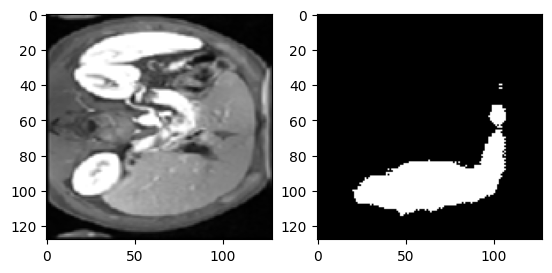

In [128]:
#plt.figure(figsize=(10, 10))
#plt.title('Максимальная сегментированная область')

plt.subplot(1,2,1)
plt.imshow(max_seg, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(max_img, cmap='gray')

plt.show()

torch.Size([128, 128])


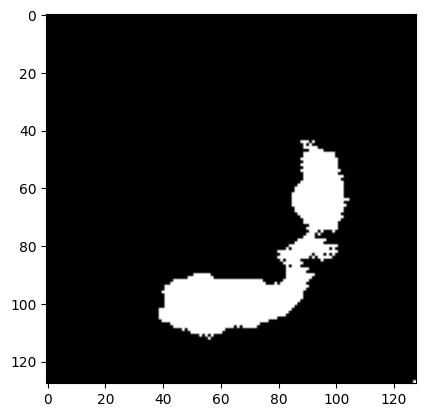

In [16]:
max_img = max(processed_images, key=lambda x:np.sum(x))
print(max_img.shape)

#print(max_img.shape, len(max_img), np.count_nonzero(max_img), max_img.size, max_img.shape[0] * max_img.shape[1])

plt.imshow(max_img, cmap='gray')
plt.show()

In [13]:
model_test_files = train_files[0:1]

model_test_ds = Dataset(data=model_test_files, transform=test_transforms)
model_test_loader = DataLoader(model_test_ds, batch_size=1)

In [42]:
sw_batch_size = 4
roi_size = (128, 128, 64)
with torch.no_grad():
    #processed_images = []
    for j, test_patient in enumerate(model_test_loader): 
        if j == 0:
            t_volume = test_patient['vol']
            
            test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
            sigmoid_activation = Activations(sigmoid=True)
            test_outputs = sigmoid_activation(test_outputs)
            test_outputs = test_outputs > 0.34
                
            for i in range(test_patient['vol'].shape[-1]):
                if i >= 0:

                    plt.figure("check", (18, 6))
                    plt.subplot(1, 3, 1)
                    plt.title(f"image {i}")
                    plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
                    plt.subplot(1, 3, 2)
                    plt.title(f"label {i}")
                    plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
                    plt.subplot(1, 3, 3)
                    plt.title(f"output {i}")

                    #processed_image = test_outputs.detach().cpu()[0, 1, :, :, i]
                    #processed_images.append(processed_image)
                    plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
                    plt.show()

NameError: name 'model_test_loader' is not defined

In [40]:
import numpy as np
import monai

# Предположим, у вас есть объект MetaTensor mask, представляющий двумерную маску печени
mask = monai.data.meta_tensor.MetaTensor(np.array([[0, 0, 0, 0, 0],
                                                  [0, 1, 1, 1, 0],
                                                  [0, 1, 1, 1, 0],
                                                  [0, 1, 1, 1, 0],
                                                  [0, 0, 0, 0, 0]]))

# Получение аффинных преобразований из метаданных объекта MetaTensor
affine_transforms = mask.meta.get('affine', None)

# Проверка наличия аффинных преобразований
if affine_transforms is not None:
    # Выбор только части аффинных преобразований, относящихся к конкретной проекции
    projection_affine = affine_transforms[:2, :2]  # Пример: выбор первых двух строк и столбцов

    # Применение выбранных аффинных преобразований к размерам маски
    mask_size_px = np.array(mask.shape)
    mask_size_mm = np.dot(projection_affine, mask_size_px)

    # Вычисление размеров объекта в миллиметрах
    object_width_mm = mask_size_mm[0]
    object_height_mm = mask_size_mm[1]

    print(f"Ширина объекта: {object_width_mm:.2f} мм")
    print(f"Высота объекта: {object_height_mm:.2f} мм")
else:
    print("Аффинные преобразования не найдены в метаданных объекта MetaTensor.")

Ширина объекта: 5.00 мм
Высота объекта: 5.00 мм


In [41]:
import cv2
from monai.utils.type_conversion import convert_to_numpy

img = convert_to_numpy(max_img)
img = img.astype(int)

plt.imshow(img)

NameError: name 'max_img' is not defined

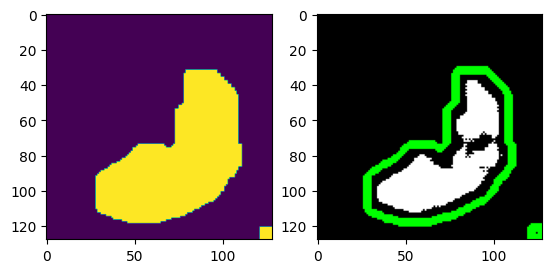

In [48]:
import cv2

mask_np = max_img.get_array()
mask_uint8 = (mask_np * 255).astype(np.uint8)

max_copy = mask_uint8.copy()

kernel = np.ones((5,5),np.uint8)
max_copy = cv2.dilate(max_copy, kernel, iterations=3)



contours, _ = cv2.findContours(max_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

image_contours = cv2.cvtColor(mask_uint8, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_contours, contours, -1, (0, 255, 0), cv2.LINE_4)

plt.subplot(1, 2, 1)
plt.imshow(max_copy)
plt.subplot(1,2,2)
plt.imshow(image_contours)

plt.show()
# Отображение изображения с контурами
#cv2.imshow('Contours Image', image_contours)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

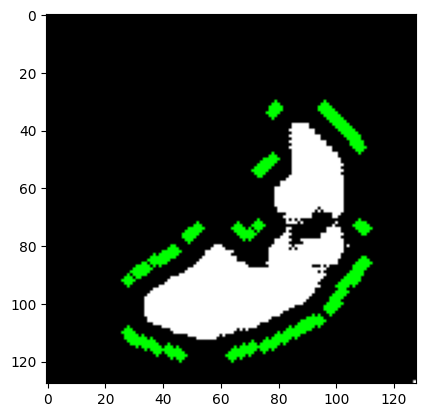

In [49]:
max_cont = max(contours, key=cv2.contourArea)
image_contours = cv2.cvtColor(mask_uint8, cv2.COLOR_GRAY2BGR)
cv2.drawContours(image_contours, max_cont, -1, (0,255,0), cv2.LINE_4)

#cv2.imshow('cont', image_contours)
plt.imshow(image_contours)

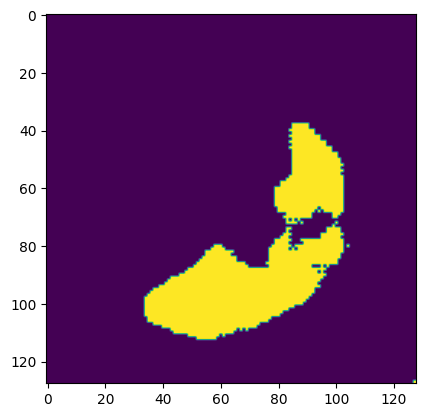

: 

In [22]:
plt.imshow(max_img)

In [2]:
from monai.transforms import(
    LoadImaged,
    Compose,
    ToTensord,
    EnsureChannelFirstd,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
)

In [35]:
single_transforms = Compose([
    LoadImaged(keys=['vol']),
    EnsureChannelFirstd(keys=['vol']),
    Spacingd(keys=['vol'], pixdim=(2, 2, 1.5), mode = ('bilinear')),
    Orientationd(keys=['vol'], axcodes='RAS'),
    ScaleIntensityRanged(keys=['vol'], a_min=-100, a_max=400, b_min=0.0, b_max=1.0,clip=True),
    CropForegroundd(keys=['vol'], source_key='vol'),
    Resized(keys=['vol'], spatial_size=[128, 128, 128]),
    ToTensord(keys=['vol'])
])

c:\Users\Вадим\AppData\Local\Programs\Python\Python311\Lib\site-packages\monai\utils\deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [36]:
_img_path = os.path.normpath('D:/GraduateWorkData/nifti_files2/22vs8/TrainImages/liver_1_0.nii.gz')
data = {'vol': _img_path}
                             

In [37]:
transformed_data = single_transforms(data)

TypeError: Invalid shape (128, 128, 128) for image data

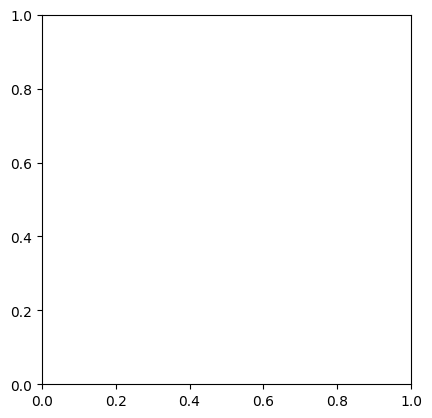

In [51]:
plt.imshow(transformed_data['vol'][0])

In [26]:
#print(_img)

img_data = _img.get_fdata()

print(img_data.shape)

img_transformed = single_transforms(img_data)

print(img_transformed)


(256, 208, 30)


RuntimeError: applying transform <monai.transforms.utility.array.EnsureChannelFirst object at 0x000001FBC8238310>